# Multi-SKU Inventory Simulation Integration
loops through every (store, item) combination in  forecast.csv, simulates EOQ + ROP inventory control, and outputs a summary table.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
forecast_df = pd.read_csv(
    r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\forecast.csv',
    parse_dates=['date'],
    dayfirst=True
)

# Ensure correct types
forecast_df['store'] = forecast_df['store'].astype(int)
forecast_df['item'] = forecast_df['item'].astype(int)
forecast_df = forecast_df.sort_values(['store', 'item', 'date']).reset_index(drop=True)

In [4]:
ordering_cost = 20     # S: cost per order
holding_cost = 50      # H: holding cost per unit per year
lead_time = 7          # days
z = 1.65               # service level (95%)
max_days_to_order = 90 # cap EOQ (optional)

In [5]:
# Results collector
summary_records = []


# Simulate for each (store, item)

In [ ]:

for (store_id, item_id), group in forecast_df.groupby(['store', 'item']):
    subset = group.copy().sort_values('date').reset_index(drop=True)

    # --- Demand statistics ---
    avg_daily_demand = subset['sales'].mean()
    std_daily_demand = subset['sales'].std(ddof=1)
    annual_demand = avg_daily_demand * 365

    # --- EOQ & ROP calculations ---
    EOQ = np.sqrt((2 * annual_demand * ordering_cost) / holding_cost)
    EOQ = min(EOQ, avg_daily_demand * max_days_to_order)
    safety_stock = z * std_daily_demand * np.sqrt(lead_time)
    ROP = avg_daily_demand * lead_time + safety_stock

    initial_stock = int(ROP + EOQ / 2)
    stock = initial_stock
    order_outstanding = False
    arrival_index = None

    inventory_levels = []
    reorder_flags = []
    stockout_days = 0
    orders_placed = []

    # --- Simulation loop ---
    for i, row in subset.iterrows():
        # Receive order if it arrives today
        if order_outstanding and arrival_index == i:
            stock += EOQ
            order_outstanding = False
            arrival_index = None

        # Deduct sales (demand)
        stock -= row['sales']

        # Stockout check
        if stock < 0:
            stockout_days += 1
            stock = 0  # no negative stock

        # Reorder condition
        if (stock <= ROP) and (not order_outstanding):
            arrival_idx = i + lead_time
            orders_placed.append((i, row['date'], int(EOQ), arrival_idx))
            order_outstanding = True
            arrival_index = arrival_idx
            reorder_flags.append(1)
        else:
            reorder_flags.append(0)

        inventory_levels.append(stock)

    # Attach results to subset (optional for visualization)
    subset['inventory_level'] = inventory_levels
    subset['reorder'] = reorder_flags

    # --- Performance metrics ---
    total_orders = len(orders_placed)
    avg_inventory = np.mean(inventory_levels)
    horizon_days = len(subset)
    service_level = 1 - (stockout_days / horizon_days)
    
    # --- Record summary ---
    summary_records.append({
        "Store": store_id,
        "Item": item_id,
        "EOQ": round(EOQ, 2),
        "ROP": round(ROP, 2),
        "Avg Inventory": round(avg_inventory, 2),
        "Orders Placed": total_orders,
        "Stockout Days": stockout_days,
        "Service Level": round(service_level, 4)
    })

# Summary Table

In [ ]:
summary_df = pd.DataFrame(summary_records)
summary_df = summary_df.sort_values(["Store", "Item"]).reset_index(drop=True)

print("Inventory Simulation Summary:")
display(summary_df.head(10))

Inventory Simulation Summary:


,Store,Item,EOQ,ROP,Avg Inventory,Orders Placed,Stockout Days,Service Level
0,1,1,77.70,174.13,49.08,13,36,0.6000
1,1,2,109.57,315.95,27.99,13,56,0.3778
2,1,3,92.22,223.33,30.28,13,45,0.5000
3,1,4,102.98,277.44,28.02,13,52,0.4222
4,1,5,77.68,173.98,47.88,13,36,0.6000
5,1,6,86.62,204.63,34.87,13,42,0.5333
6,1,7,124.74,418.98,30.31,13,60,0.3333
7,1,8,103.19,277.62,27.39,13,53,0.4111
8,1,9,115.97,359.07,28.60,13,60,0.3333
9,1,10,86.39,203.53,34.04,13,43,0.5222


# save results

In [9]:
summary_df.to_csv(
    r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\inventory_summary.csv',
    index=False
)
print("✅ Inventory summary saved as inventory_summary.csv")

✅ Inventory summary saved as inventory_summary.csv


# example viz

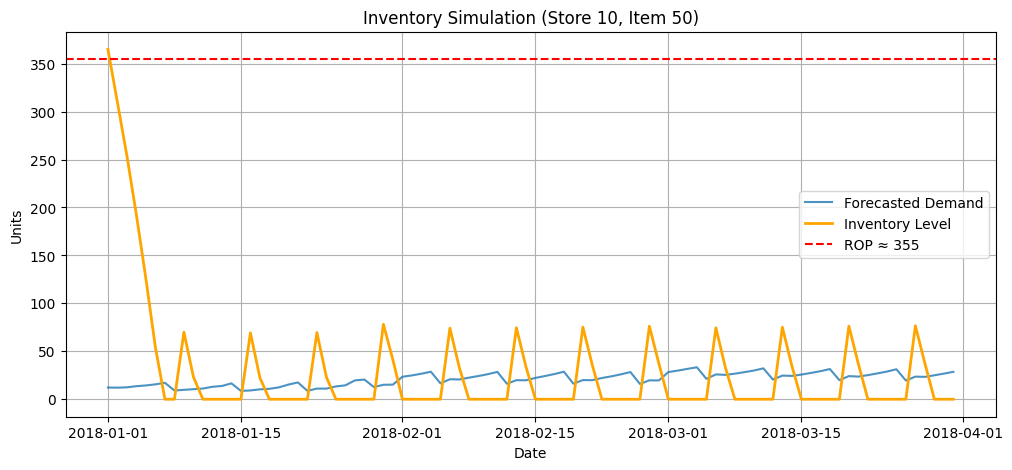

In [10]:
example = forecast_df[(forecast_df["store"] == 1) & (forecast_df["item"] == 1)].copy()
plt.figure(figsize=(12,5))
plt.plot(example['date'], example['sales'], label='Forecasted Demand', alpha=0.8)
plt.plot(subset['date'], subset['inventory_level'], label='Inventory Level', color='orange', linewidth=2)
plt.axhline(ROP, color='red', linestyle='--', label=f'ROP ≈ {ROP:.0f}')
plt.title(f"Inventory Simulation (Store {store_id}, Item {item_id})")
plt.xlabel("Date")
plt.ylabel("Units")
plt.legend()
plt.grid(True)
plt.show()